## Level 5: Unit sales of all products, aggregated for each department

In [1]:
import os
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

from tsforest.trend import compute_trend_models
from tsforest.forecaster import LightGBMForecaster

# local modules
import sys
sys.path.append("../lib/")
from utils import compute_scaling, reduce_mem_usage
from evaluation import WRMSSEEvaluator

SEEDS = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71]

/home/turing/miniconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



***

In [3]:
data = (pd.read_parquet("../input/train_dataframe.parquet")
        .groupby(["dept_id","ds"])
        .agg({"q":"sum",
              "event_name_1":lambda x: int(x.unique()),
             })
        .reset_index()
       )

data["q"] = data.q.astype(int)
data.rename({"q":"y"}, axis=1, inplace=True)
data.sort_values(["dept_id","ds"], inplace=True)
data.reset_index(drop=True, inplace=True)

In [7]:
weights_level5 = pd.read_parquet("../input/weights_level5.parquet")
weights_level5.head(10)

,dept_id,weight
0,5,0.062625
1,6,0.154642
2,7,0.351318
3,1,0.122088
4,2,0.005991
5,3,0.229594
6,4,0.073741


In [9]:
scaling_input = pd.read_parquet("../input/scaling_input.parquet")
scales = compute_scaling(scaling_input, agg_columns=["dept_id"]).rename({"q":"s"}, axis=1)
scales.head(10)

,dept_id,s
0,1,555.257792
1,2,61.402289
2,3,1209.526246
3,4,308.876054
4,5,473.184405
5,6,732.283043
6,7,3050.310085


In [11]:
weights = (weights_level5
    .merge(scales, how="inner", on=["dept_id"])
    .assign(weight = lambda x: x.weight/x.s)
    .assign(weight = lambda x: x.weight/x.weight.median())
    .drop(["s"], axis=1)
)
weights.head(10)

,dept_id,weight
0,5,0.697228
1,6,1.112509
2,7,0.606752
3,1,1.158326
4,2,0.514049
5,3,1.000000
6,4,1.257704


In [13]:
data = pd.merge(data, weights, how="left", on=["dept_id"])
data.head()

,dept_id,ds,y,event_name_1,weight
0,1,2011-01-29,3610,1,1.158326
1,1,2011-01-30,3172,1,1.158326
2,1,2011-01-31,2497,1,1.158326
3,1,2011-02-01,2531,1,1.158326
4,1,2011-02-02,1714,1,1.158326


***
### time series visualization

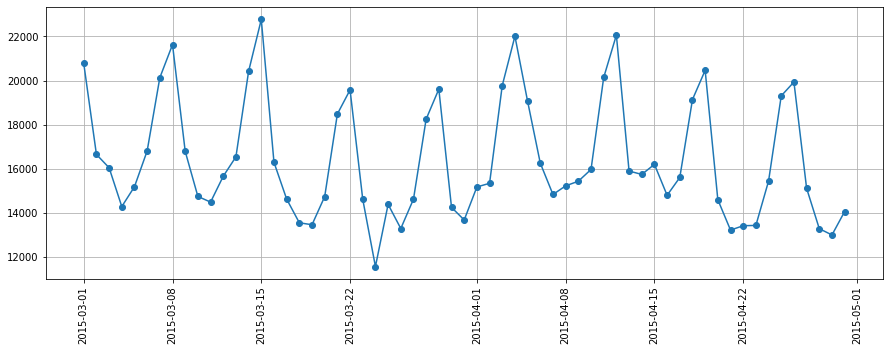

In [22]:
dept_id = 7
start_date = '2015-03-01'
end_date = '2015-04-30'

df = data.query("dept_id == @dept_id & @start_date <= ds <= @end_date")

plt.figure(figsize=(15,5))
plt.plot_date(df.ds, df.y, "o-")
plt.xticks(rotation=90)
plt.grid()
plt.show()

***

In [23]:
valid_periods = [(pd.to_datetime("2015-04-25"), pd.to_datetime("2015-05-22")),
                 (pd.to_datetime("2015-05-23"), pd.to_datetime("2015-06-19")),
                 (pd.to_datetime("2016-01-29"), pd.to_datetime("2016-02-26")),
                 (pd.to_datetime("2016-02-27"), pd.to_datetime("2016-03-26")),
                 (pd.to_datetime("2016-03-27"), pd.to_datetime("2016-04-24")),
                ]
valid_periods

[(Timestamp('2015-04-25 00:00:00'), Timestamp('2015-05-22 00:00:00')),
 (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')),
 (Timestamp('2016-01-29 00:00:00'), Timestamp('2016-02-26 00:00:00')),
 (Timestamp('2016-02-27 00:00:00'), Timestamp('2016-03-26 00:00:00')),
 (Timestamp('2016-03-27 00:00:00'), Timestamp('2016-04-24 00:00:00'))]

***
### training validation models

In [24]:
model_params = {
    'objective':'l2',
    'metric':'None',
    'num_iterations':10000,
    'early_stopping_rounds':250,
    #'max_bin': 255,
    'num_leaves': 23, 
    'learning_rate': 0.1, 
    'min_data_in_leaf': 20,
    #'min_sum_hessian_in_leaf':1e-4,
    'feature_fraction': 0.66,
    'bagging_fraction':0.9,
    'bagging_freq':1,
    'lambda_l2':1.,
    'seed':23
}

time_features = [
    "year",
    "month",
    "year_week",
    "year_day",
    "week_day",
    "month_progress",
    "week_day_cos",
    "week_day_sin",
    "year_day_cos",
    "year_day_sin",
    "year_week_cos",
    "year_week_sin",
    "month_cos",
    "month_sin"
]

model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "categorical_features":{
        "dept_id":"default",
        "event_name_1":"default"},
    "ts_uid_columns":["dept_id"],
    
}

In [25]:
# 4+ years of history
train_history = 1800

In [26]:
models = list()
errors = list()
best_iterations = list()

for i,valid_period in enumerate(valid_periods):
    print(f" {i+1}/{len(valid_periods)} ".center(100, "#"))
    print(f" Validation period: {valid_period} ".center(100, "#"))
    print("#"*100)
    
    valid_start = valid_period[0]
    valid_end = valid_period[1]
    
    train_start = valid_start - pd.DateOffset(days=train_history)
        
    _train_data = data.query("@train_start <= ds <= @valid_end").reset_index(drop=True)
    _valid_index = _train_data.query("@valid_start <= ds <= @valid_end").index

    _fcaster = LightGBMForecaster(**model_kwargs)
    _fcaster.prepare_features(train_data=_train_data, valid_index=_valid_index);

    _fcaster.train_features = reduce_mem_usage(_fcaster.train_features)
    _fcaster.valid_features = reduce_mem_usage(_fcaster.valid_features)
    
    evaluator = WRMSSEEvaluator(_fcaster.valid_features.loc[:, ["ds"]+_fcaster.ts_uid_columns+["y"]], 
                                weights_level5, 
                                scales,
                                ts_uid_columns=_fcaster.ts_uid_columns)
    _fcaster.fit(fit_kwargs={"verbose_eval":25, "feval":evaluator.evaluate})

    
    models.append(_fcaster)
    errors.append(_fcaster.model.model.best_score["valid_0"]["wrmsse"])
    best_iterations.append(_fcaster.best_iteration)

############################################### 1/5 ################################################
##### Validation period: (Timestamp('2015-04-25 00:00:00'), Timestamp('2015-05-22 00:00:00')) ######
####################################################################################################
Training until validation scores don't improve for 250 rounds
[25]	valid_0's wrmsse: 0.982854
[50]	valid_0's wrmsse: 0.581004
[75]	valid_0's wrmsse: 0.576828
[100]	valid_0's wrmsse: 0.557543
[125]	valid_0's wrmsse: 0.538603
[150]	valid_0's wrmsse: 0.526717
[175]	valid_0's wrmsse: 0.519092
[200]	valid_0's wrmsse: 0.508309
[225]	valid_0's wrmsse: 0.499694
[250]	valid_0's wrmsse: 0.491642
[275]	valid_0's wrmsse: 0.487529
[300]	valid_0's wrmsse: 0.486265
[325]	valid_0's wrmsse: 0.486171
[350]	valid_0's wrmsse: 0.482047
[375]	valid_0's wrmsse: 0.477375
[400]	valid_0's wrmsse: 0.473378
[425]	valid_0's wrmsse: 0.468401
[450]	valid_0's wrmsse: 0.465681
[475]	valid_0's wrmsse: 0.464535
[500]	valid

In [27]:
np.mean(errors)

0.5058401784130122

In [28]:
np.mean(best_iterations)

1403.6

***
### training final model

In [28]:
model_kwargs["model_params"]["num_iterations"] = int(np.median(best_iterations))
model_kwargs["model_params"]

{'objective': 'l2',
 'metric': 'None',
 'num_iterations': 519,
 'early_stopping_rounds': 250,
 'num_leaves': 23,
 'learning_rate': 0.1,
 'min_data_in_leaf': 20,
 'feature_fraction': 0.66,
 'bagging_fraction': 0.9,
 'bagging_freq': 1,
 'lambda_l2': 1.0,
 'seed': 71}

In [29]:
train_data = data.copy(deep=True)
all_models = list()

for seed in SEEDS:
    model_kwargs["model_params"]["seed"] = seed
    fcaster = LightGBMForecaster(**model_kwargs)
    fcaster.prepare_features(train_data=train_data);
    fcaster.fit()
    all_models.append(fcaster)

***
### prediction

In [21]:
valid_dataframe = (pd.read_parquet("../input/valid_dataframe.parquet")
                   .loc[:, ["ds","cat_id","event_name_1"]]
                   .drop_duplicates()
                   .merge(weights, how="left", on="cat_id"))
eval_dataframe = (pd.read_parquet("../input/eval_dataframe.parquet")
                  .loc[:, ["ds","cat_id","event_name_1"]]
                  .drop_duplicates()
                  .merge(weights, how="left", on="cat_id"))

In [23]:
all_forecasts = list()
for fcaster in all_models:
    _forecast = fcaster.predict(pd.concat([valid_dataframe, valid_dataframe], ignore_index=True))
    all_forecasts.append(_forecast)
    
forecast = all_forecasts[0].copy(deep=True)
forecast["y_pred"] = np.mean([_forecast.y_pred for _forecast in all_forecasts], axis=0)

In [24]:
forecast

,ds,state_id,y_pred
0,2016-04-25,1,16650.396352
1,2016-04-26,1,15232.303615
2,2016-04-27,1,14639.942760
3,2016-04-28,1,14639.617834
4,2016-04-29,1,16844.384815
...,...,...,...
163,2016-05-18,3,10645.395057
164,2016-05-19,3,10644.625792
165,2016-05-20,3,12284.102027
166,2016-05-21,3,14288.317752


***